In [1]:
# %% Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [2]:
# %% Load and Preprocess the Dataset

newsgroup = fetch_20newsgroups(subset="all")
X = newsgroup.data
y = newsgroup.target

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=100)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

In [3]:
# %% Define the F1 Score Metric

from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    
    tp = K.sum(K.cast(y_true * y_pred, "float"), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, "float"), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), "float"), axis=0)
    
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return K.mean(f1)

In [4]:
# %% Build the LSTM Model

def build_lstm_model():
    model = Sequential()

    model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation="softmax"))
    
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy", f1_score])

    return model

model = build_lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 674,324
Trainable params: 674,324
Non-trainable params: 0
_________________________________________________________________


In [5]:
# %% Train the LSTM Model

early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/5
424/424 [==============================] - 26s 55ms/step - loss: 2.6397 - accuracy: 0.1506 - f1_score: 6.5255e-04 - val_loss: 2.1171 - val_accuracy: 0.2878 - val_f1_score: 0.0051
Epoch 2/5
424/424 [==============================] - 23s 54ms/step - loss: 1.9225 - accuracy: 0.3490 - f1_score: 0.0135 - val_loss: 1.7659 - val_accuracy: 0.4005 - val_f1_score: 0.0181
Epoch 3/5
424/424 [==============================] - 23s 54ms/step - loss: 1.5252 - accuracy: 0.4719 - f1_score: 0.0319 - val_loss: 1.5354 - val_accuracy: 0.5212 - val_f1_score: 0.0360
Epoch 4/5
424/424 [==============================] - 24s 56ms/step - loss: 1.1878 - accuracy: 0.5988 - f1_score: 0.0524 - val_loss: 1.3021 - val_accuracy: 0.5895 - val_f1_score: 0.0566
Epoch 5/5
424/424 [==============================] - 23s 55ms/step - loss: 0.9761 - accuracy: 0.6851 - f1_score: 0.0662 - val_loss: 1.3556 - val_accuracy: 0.5836 - val_f1_score: 0.0536


118/118 [==============================] - 2s 15ms/step - loss: 1.3602 - accuracy: 0.5679 - f1_score: 0.0535
Test loss: 1.3602, Test Accuracy: 0.5679


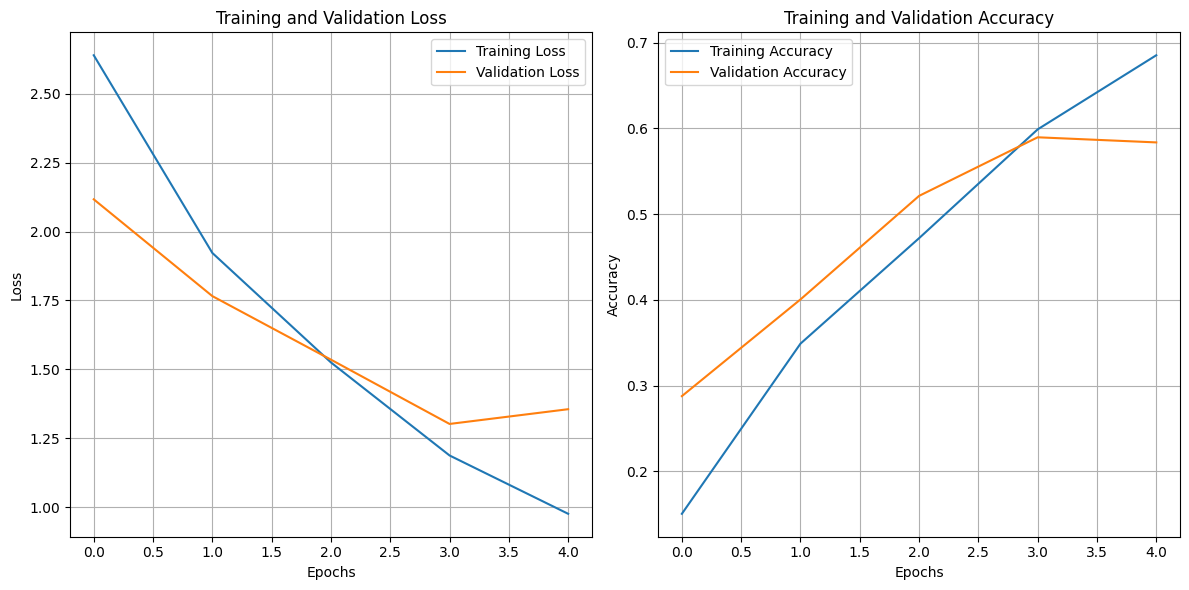

In [7]:
# %% Model Evaluation

loss, accuracy, *_ = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()